1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

In [36]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline

import random

from sklearn import datasets
from sklearn import model_selection

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [37]:
random.seed(50)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [38]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [39]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [40]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction        

In [41]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [42]:
def quality(left_labels, right_labels, current_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [43]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [44]:
def find_best_split(data, labels):
    
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [45]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [46]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest

In [47]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [48]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [49]:
def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [50]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [51]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=100,
    n_features = 2, 
    n_informative = 2, 
    n_classes = 2, 
    n_redundant=0, 
    n_clusters_per_class=1,
    random_state=50
)

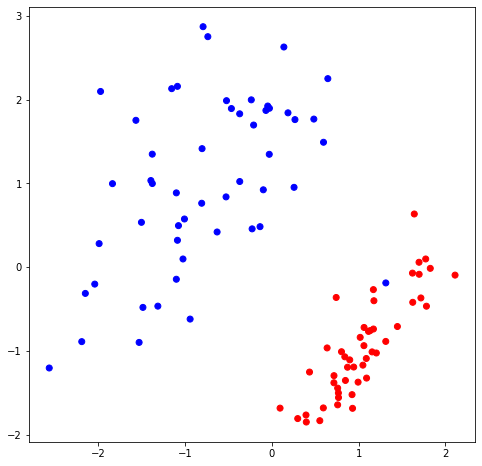

In [52]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [53]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 14)

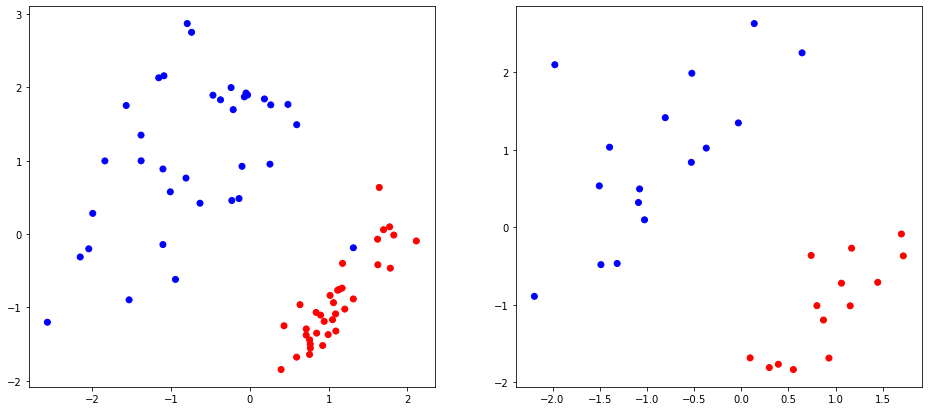

In [54]:
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)

plt.subplot(1,2,2)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.show()

In [55]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [56]:
GLOB=[]

def get_report(train_data, train_labels, test_data, test_labels, n_trees):
    global GLOB
    my_forest=random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
        
    plt.figure(figsize = (16, 7))
        
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'N_trees={n_trees}\nTrain accuracy={train_accuracy:.2f}')
        
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'N_trees={n_trees}\nTest accuracy={test_accuracy:.2f}')
        
    GLOB.append([n_trees,train_accuracy,test_accuracy])

Точность случайного леса из 1 деревьев на обучающей выборке: 95.714
Точность случайного леса из 1 деревьев на тестовой выборке: 93.333


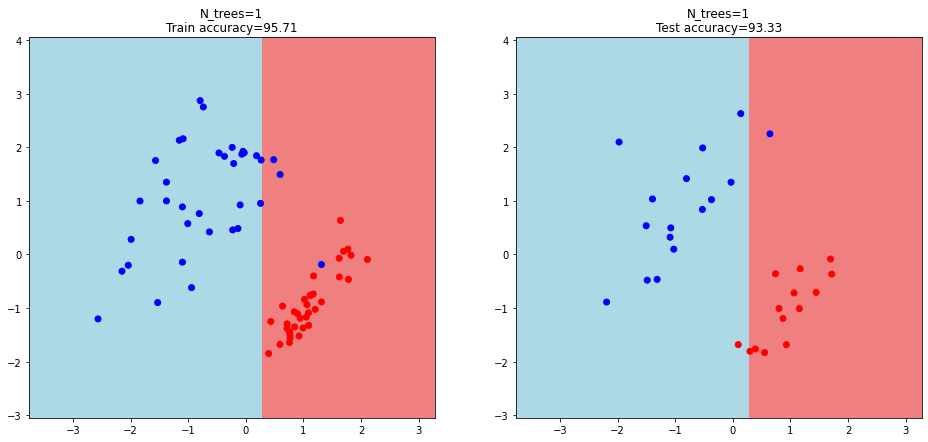

In [57]:
get_report(train_data, train_labels, test_data, test_labels, 1)

Точность случайного леса из 3 деревьев на обучающей выборке: 94.286
Точность случайного леса из 3 деревьев на тестовой выборке: 86.667


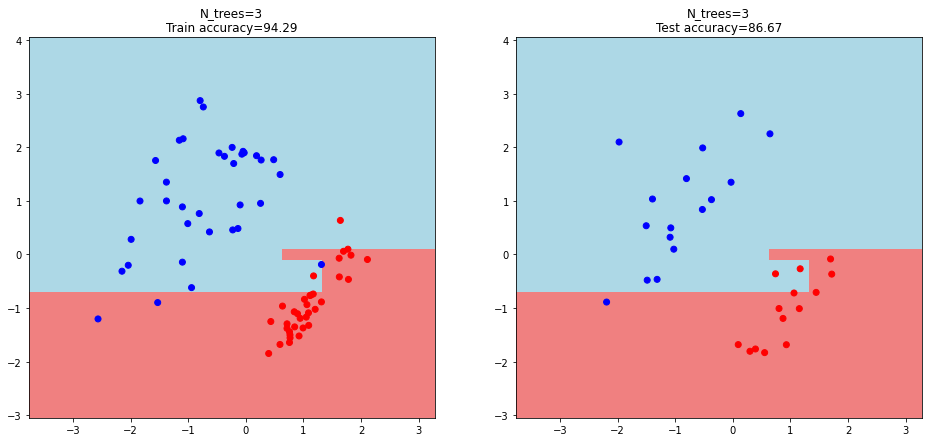

In [58]:
get_report(train_data, train_labels, test_data, test_labels, 3)

Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667


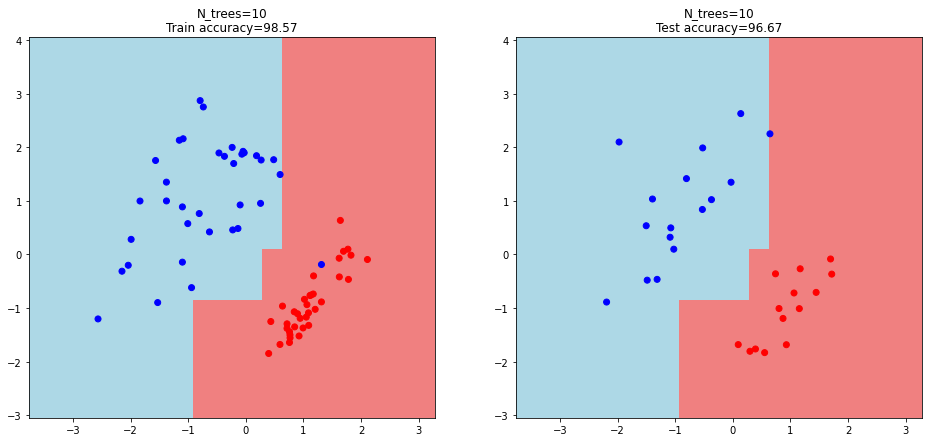

In [59]:
get_report(train_data, train_labels, test_data, test_labels, 10)

Точность случайного леса из 50 деревьев на обучающей выборке: 98.571
Точность случайного леса из 50 деревьев на тестовой выборке: 93.333


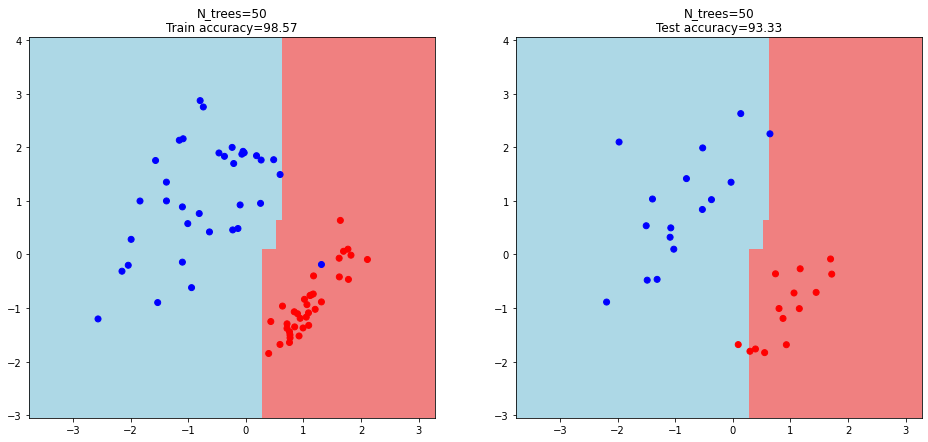

In [60]:
get_report(train_data, train_labels, test_data, test_labels, 50)

In [61]:
report=pd.DataFrame(GLOB, columns=['n_trees', 'train_accuracy','test_accuracy'])
report

,n_trees,train_accuracy,test_accuracy
0,1,95.714286,93.333333
1,3,94.285714,86.666667
2,10,98.571429,96.666667
3,50,98.571429,93.333333


ВЫВОД: с увеличением числа деревьев модель не переобучается, ошибка на тренировочной и тестовой моделях выходит на асимптоту. По мере увеличения числа деревьев разделяющая гиперплоскость избавляется от длинных тонких линий, которые говорят о попытке модели подстроится под данные, она становится более простой, не теряя своей эффективности.

3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

Каждое дерево, составляющее случайный лес, строится на основе бутстрапированной выборки. При этом примерно часть объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, что называется out-of-bag error. Для каждог объекта находятся деревья, которые на нем не обучались, и вычисляется ошибка, как сумма значений ошибки для среднего ответа на каждом объекте среди деревьев, которые на нем не обучались.

In [62]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_idx=set() 
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_idx.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels, b_idx))
        
    return bootstrap

In [63]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    f_idx=[]
    for b_data, b_labels, b_idx in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        f_idx.append(b_idx)
        
    return forest, f_idx

In [64]:
def tree_vote(forest, f_idx, data,labels):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    vote_count=0
    err_count=0
    for i in range(len(data)):
        data_pred=[]
        for j in range(len(f_idx)):
            if i in f_idx[j]:
                continue
            data_pred.append(*predict([data[j]], forest[j]))
        if data_pred:
            if max(data_pred, key=data_pred.count)!=labels[i]:
                err_count+=1
            vote_count+=1
    oob=err_count/vote_count
        
    return voted_predictions, oob

In [65]:
my_forest_50=random_forest(classification_data, classification_labels, 50)

In [66]:
answ, out_of_bag = tree_vote(my_forest_50[0],my_forest_50[1],classification_data, classification_labels)
print(f'Out of bag error: {out_of_bag:.2f}')

Out of bag error: 0.56


In [67]:
accuracy = accuracy_metric(classification_labels, answ)
accuracy

98.0

ВЫВОД: значение ошибки достаточно велико, модель в 56% случаев ошибается на объектах, не участвовавших в построении леса.